# FEATURE ENGINEERING WITH LINEAR REGRESSION

It is possible to automatically select features in your data that are most useful or most relevant for the problem you are working on. This is a process called feature selection.Feature selection part is maybe the most crucial one for a machine learning project. It is standart for every project no mather what the problem is. Quality of the feature set directly effects the health of the model. Actually, machine learning is all about determining correct feature set.Especially in long term big projects, tens of people try to increase accuracy 97% to 98% just by trying different feature set configurations !

In this article, we will do some feature engineering and use linear regression as our base model.

Before dive in to the project, we have to get to know a little bit about the data. Data is taken from Turkey Super Futbol League between seasons of 2007 to 2015.It includes teams, players, age of players, nationality, market value of players and the points of each team at the end of the season. As you might have guessed, we will try to predict the points and ranks of the teams for a given season.








# Import required libraries


In [70]:

import time
import os

import pandas as pd # for dataframe operations. 
import numpy as np #for linear algebra operations.
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt # for plotting

from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.stats import kendalltau # we will

# Read data

The data consist of two sheets in an excel file. 
First sheet includes info about the teams for each season and second sheet includes corresponding points for each team.The Clubs per Season is set as the index to join the dataframes together.
Sorting makes them in the same order to avoid a possible shift.

In [126]:
points_df = pd.read_excel('Data\\TurkeySuperLeague.xlsx', sheet_name='Points')
players_df = pd.read_excel('Data\\TurkeySuperLeague.xlsx', sheet_name='Player')

# Adding ranking column to the points table
points_df['Ranking'] = points_df.groupby('Season')['Points'].rank(ascending=False,method='first')

points_group_sc = points_df.set_index(['Season','Club']).sort_index()
players_group_sc = players_df.set_index(['Season','Club']).sort_index()

After reading points and player datasheets seperately, let's join them now.
Because we sorted both dataframes according to Season and the Clup columns, there will be no missmatch between datapoints.

In [127]:
# Joining the dataframes together as a new dataframe
whole_df = pd.DataFrame(players_group_sc)
whole_df['Points'] = points_group_sc['Points'].copy()
whole_df.head()

Player  Age  Foreign Nationality  Multinational  \
Season Club                                                                     
2007   Ankaragücü             Mateus   24        1      Brazil              0   
       Ankaragücü    Tevfik Altindag   18        0      Turkey              0   
       Ankaragücü  Abdülkadir Kayali   16        0      Turkey              0   
       Ankaragücü       Engin Aktürk   23        0      Turkey              0   
       Ankaragücü  Gökhan Emreciksin   22        0      Turkey              0   

                   Market Value  Points  
Season Club                              
2007   Ankaragücü         25000    43.0  
       Ankaragücü         50000    43.0  
       Ankaragücü        100000    43.0  
       Ankaragücü        100000    43.0  
       Ankaragücü        100000    43.0

It always a good idea to get description and information as much as possible about the data before work. 

In [138]:
# let's get some description about our main dataframe
whole_df.describe()

,Age,Foreign,Multinational,Market Value,Points,Ranking
count,4778.000000,4778.000000,4778.000000,4.778000e+03,4761.000000,4761.000000
mean,25.520301,0.501884,0.278778,1.721085e+06,45.779668,9.859273
std,4.093131,0.500049,0.448445,2.231122e+06,14.041953,5.162399
min,14.000000,0.000000,0.000000,2.500000e+04,11.000000,1.000000
25%,23.000000,0.000000,0.000000,4.500000e+05,37.000000,5.000000
50%,26.000000,1.000000,0.000000,1.000000e+06,44.000000,10.000000
75%,28.000000,1.000000,1.000000,2.000000e+06,53.000000,14.000000
max,38.000000,1.000000,1.000000,3.200000e+07,82.000000,18.000000


Now we have our features. A good feature engineering starts with a good understanding about how each feature affects the output.In other words, how each feature is correlated with the output.

Along with that,understanding correlation between the features is also crucial for the sake of our model. 

Here, we will use famous technique of heatmap of seaborn library. 

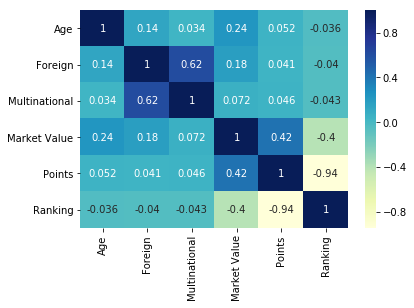

In [139]:
correlation = whole_df.corr() #corr() method of pandas library calculates correlation between columns of dataframe

sns.heatmap(correlation,cmap="YlGnBu",annot=True)
plt.show()



As expected, correlation at the diagonal is full of '1's. It seems there is no too high correlation between features. And it also seems Market Value is most correlated one with the output. Of course it is ! Everything is highly correlated with money in life :) 

# Search For New Features

Here the most interesting part begins. We have some features like nationality, age , market value etc. Actually, There are more which hidden in the columns of our dataframe ! With some thinking and guess, we can obtain more features. Here I tried to extract some : 

* Mean of age
* Standart deviation of age
* Total foreign player count for each team in each season
* Total multinational player count for each team in each season
* Total player count for each team in each season
* Foreign player count/ Total player count 
* Total market value for each team for each season 
* Standart deviation of market value for each team in each season
* Mean of market value for each team in each season 




In [130]:
whole_df['Ranking'] = points_group_sc['Ranking'].copy()
data_means = players_df.groupby(['Season', 'Club']).mean()[['Market Value', 'Age','Foreign','Multinational']]
data_sums = players_df.groupby(['Season', 'Club']).sum()[['Market Value','Foreign','Multinational']]
total_player= players_df.groupby(['Season', 'Club']).count()['Player']
data_standart_deviations= players_df.groupby(['Season', 'Club']).std()[['Market Value', 'Age']] 
feature_df = pd.DataFrame(data_means)
player_counts_per_season = players_df.groupby(['Season', 'Club']).count()[['Player']]
feature_df['Value Ranking'] = data_means.groupby('Season')['Market Value'].rank(ascending=False,method='first')


We got some more features. Let's combine each of them in to one main dataframe. 

In [131]:
main_df = pd.DataFrame(data_means)
#main_df['Value Ranking'] = data_means.groupby('Season')['Market Value'].rank(ascending=False,method='first')

main_df['Points'] = points_group_sc['Points'].copy()
main_df['Ranking'] = points_group_sc['Ranking'].copy()
main_df['age_std'] = data_standart_deviations['Age'].copy()
main_df['multi_sum'] = data_sums['Multinational'].copy()
main_df['foreign_sum'] = data_sums['Foreign'].copy()
main_df['player_sum'] = total_player
main_df['foreign_ratio'] = (main_df['foreign_sum'] / main_df['player_sum']).copy()
main_df['market_sum'] = data_sums['Market Value'].copy()
main_df['market_std'] = data_standart_deviations['Market Value'].copy()

normalized_means = data_means.groupby(['Season']).transform(lambda x: x/x.mean())
main_df['market_norm'] = normalized_means['Market Value']
main_df['age_norm'] = normalized_means['Age']



In [132]:
main_df.head()

Market Value        Age   Foreign  Multinational  \
Season Club                                                                
2007   Ankaragücü       9.701613e+05  25.258065  0.419355       0.225806   
       Ankaraspor       1.436207e+06  24.862069  0.517241       0.379310   
       Besiktas         2.344655e+06  24.068966  0.448276       0.275862   
       Bursaspor        9.397059e+05  24.352941  0.411765       0.147059   
       Büyüksehir Bld.  9.965517e+05  25.896552  0.206897       0.034483   

                        Value Ranking  Points  Ranking   age_std  multi_sum  \
Season Club                                                                   
2007   Ankaragücü                13.0    43.0      8.0  4.545824          7   
       Ankaraspor                 5.0    41.0     10.0  3.739023         11   
       Besiktas                   3.0    73.0      3.0  4.970851          8   
       Bursaspor                 14.0    38.0     13.0  4.169749          5   
       Büyüksehir Bld.           12.0    38.0     12.0  4.768534          1   

                        foreign_sum  player_sum  foreign_ratio  market_sum  \
Season Club                                                                  
2007   Ankaragücü                13          31       0.419355    30075000   
       Ankaraspor                15          29       0.517241    41650000   
       Besiktas                  13          29       0.448276    67995000   
       Bursaspor                 14          34       0.411765    31950000   
       Büyüksehir Bld.            6          29       0.206897    28900000   

                          market_std  market_norm  age_norm  
Season Club                                                  
2007   Ankaragücü       8.178330e+05     0.716837  1.015320  
       Ankaraspor       1.149293e+06     1.061191  0.999402  
       Besiktas         1.785974e+06     1.732429  0.967521  
       Bursaspor        7.595632e+05     0.694334  0.978936  
       Büyüksehir Bld.  1.155262e+06     0.736337  1.040986

# Dive in correlation more 

We tried our best to get a good feature set. Now, it is time to examine relationship between Points and each feature.
We will use seaborn beautiful Implot method to virtualize correlation. It seems just the features related with market value provide an insight about the points. Of course Ranking is highly related with the Points. 

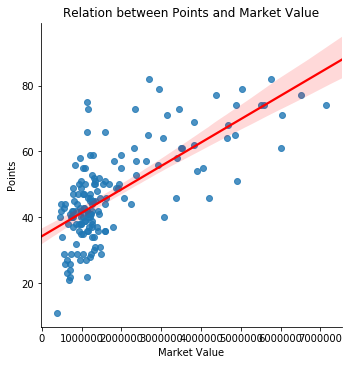

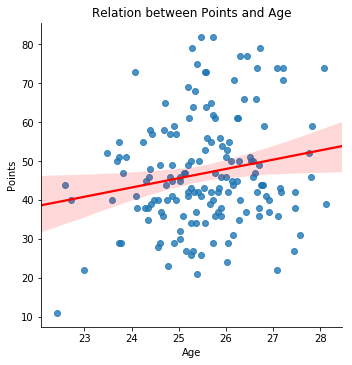

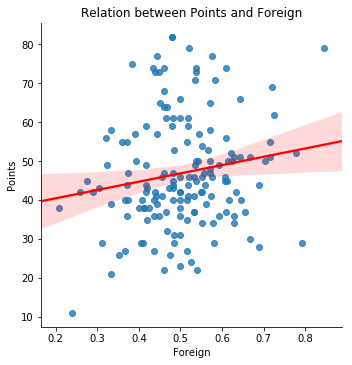

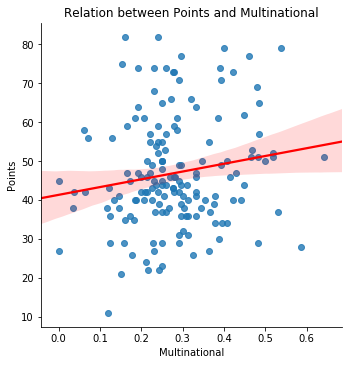

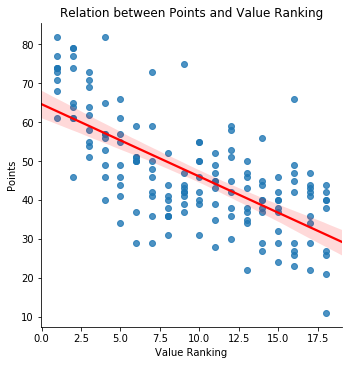

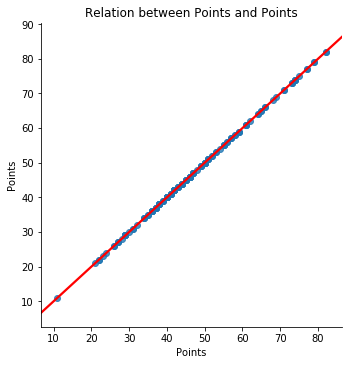

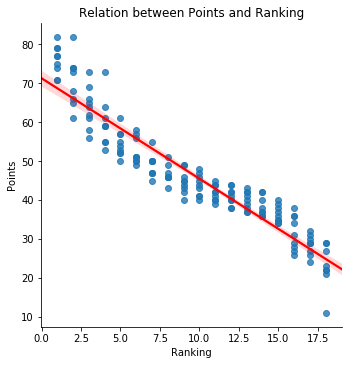

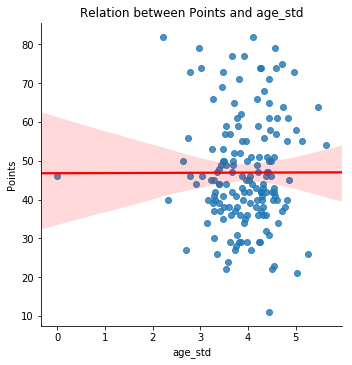

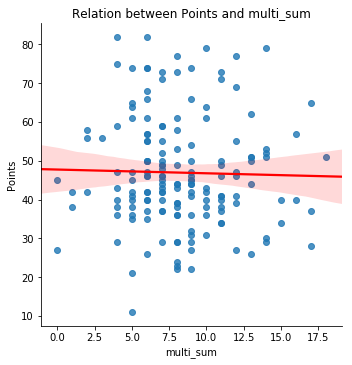

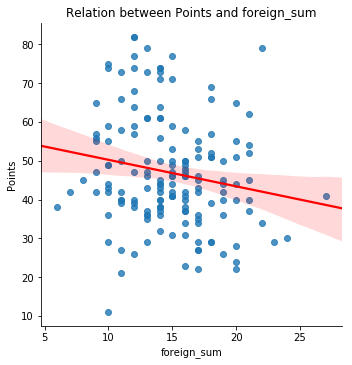

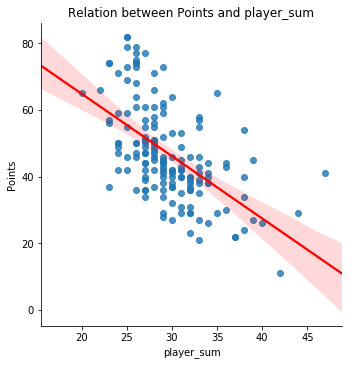

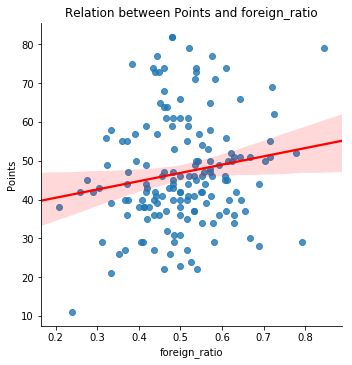

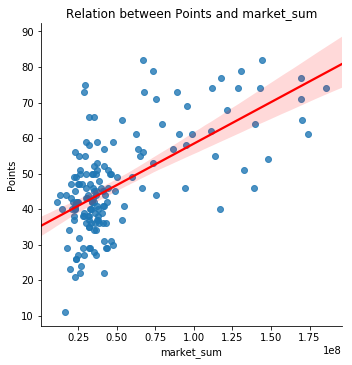

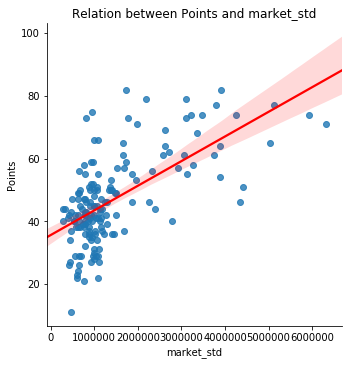

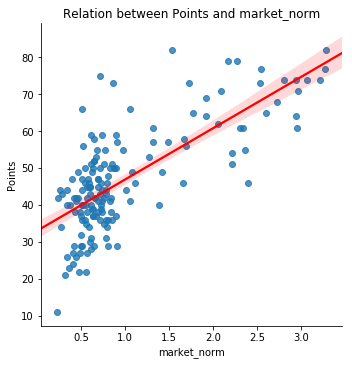

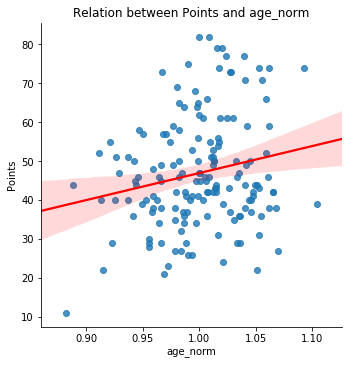

In [133]:
features=main_df.columns

for i in features:
    sns.lmplot(x=i, y="Points", data=main_df,line_kws={'color': 'red'})
    text="Relation between Points and " + i 
    plt.title(text)
    plt.show()


A little bit more correlation analysis.

Here is our last  demonstration. As you can see below, market_norm feature is the shining one. age_std,multi_sum,Multinational, foreign_ratio and foreign_sum features are not highly related to the output. 

In [134]:
correlation = main_df.corr()['Points']
# convert series to dataframe so it can be sorted
correlation_df = pd.DataFrame(correlation)
# correct column label from Points to correlation
correlation_df.columns = ["Correlation"]
# sort correlation
corr_sorted = correlation_df.sort_values(by=['Correlation'], ascending=False)
corr_sorted.head(40)

,Correlation
Points,1.000000
market_norm,0.733703
Market Value,0.700236
market_std,0.633554
market_sum,0.623709
age_norm,0.201002
Age,0.187137
Foreign,0.165547
foreign_ratio,0.165547
Multinational,0.162402


In [135]:
def convert_points_to_predictions(predictions, shouldAscend):
    predictions['Real Rank'] = predictions['Real'].rank(ascending=shouldAscend,method='first')
    predictions['Predicted Rank'] = predictions['Predict'].rank(ascending=shouldAscend,method='first')
    return predictions

# LINEAR REGRESSION 


So far so good. We got out initial feature set and will try to fit a linear regression model with it. Linear regression is the basic regression model in usage ; however it gives satisfactory results for most of the problems. Actually, we should try models as much as possible we can and compare the results in a real machine learning problem; but we will just implement linear regression for this time. 

Even through, we demonstrated that some of the features (like age_std) is not too much correlated with the target, we will not drop unrelated columns in the first step.


Our data covers seasons between 2007-2015.We could follow the classical path and use  train_test_split method of sklearn library and it will split our feature set as test and train with given configuration settings(for usage and more info: http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html). It could work fine ; but I prefer to establish a more realistic scenario. We will try to predict each season from the other seasons. For each season, we will compare predicted results with the real ones.  Kendalltau method will be our greatest supporter.


In [136]:
def train_test_on_points(final_df):
    tau_ = 0
    for season in range(2007,2015):
        train = final_df[final_df['Season']!=season] # train data is not contain target season
        test = final_df[final_df['Season']==season] #test data is all about target season.
        # We will try to predict Points.So,we have to drop it from the test dataframe. 
        # Additionaly, we don't need Season information anymore. Let's drop both
        X_train = train.drop(['Points','Season'],axis=1) 
        # we don't have to normalize y_train data; but it is proved normalization has a positive effect on accuracy. 
        
        y_train = train['Points'].transform(lambda x: (x - x.mean()) / x.std())
        #we should also drop Points and Season columns from X_test
        X_test = test.drop(['Points','Season'],axis=1)
        # normalize y_test
        y_test = test['Points'].transform(lambda x: (x - x.mean()) / x.std())
        
        #X_train, X_test, y_train , y_test = train_test_split(final_df.drop('Points',axis=1),final_df['Points'],
         #                                                    test_size=0.1, random_state=1)
        # This is the regression model you will use
        final_model = LinearRegression(fit_intercept=False)   
        # Fit our X_train and y_train for learning
        final_model.fit(X_train,y_train)
        #get scores
        score = cross_val_score(final_model,X_train, y_train,cv=10)        
        print(score)    
        
        y_predict = final_model.predict(X_test)
    
        preds = pd.DataFrame({"Predict":y_predict})
        
        preds['Real']= y_test.reset_index().iloc[:,-1]
        
        ranks = pd.DataFrame()
        
        ranks['Real Rank'] = preds['Real'].rank(ascending=False,method='first')
        
        ranks['Predicted Rank'] = preds['Predict'].rank(ascending=False,method='first')
        tau, _ = kendalltau(ranks['Predicted Rank'], ranks['Real Rank'])
        tau_ += tau
    
    print('\n')
    print('kendalltau for Points estimation: ',tau_/9)    
    
final_df=main_df.copy()
final_df.dropna(inplace=True)
final_df = final_df.reset_index()
get_dummy_for_clup_names=pd.get_dummies(final_df['Club'],drop_first=True)
final_df=final_df.join(get_dummy_for_clup_names)
final_df.drop(columns=['Club'],inplace=True)

train_test_on_points(final_df)

#final_df.head(10)

[0.84582127 0.91461515 0.90760747 0.78107141 0.70076685 0.85802387
 0.9109737  0.95352018 0.88762571 0.88796323]
[0.84780195 0.8691872  0.89248254 0.81146852 0.70531824 0.86941915
 0.91627327 0.94282058 0.89732708 0.83005279]
[0.85126788 0.80673913 0.90597799 0.79790395 0.7198098  0.8431223
 0.91335295 0.95452109 0.90791499 0.85347219]
[0.88278652 0.8284015  0.93910875 0.8813219  0.74264184 0.86668269
 0.92691253 0.95248022 0.87729922 0.81527429]
[0.84870248 0.80901141 0.91989686 0.847373   0.84095937 0.85107934
 0.90944875 0.9547534  0.90707309 0.89903163]
[0.86635063 0.83239263 0.928726   0.81890798 0.84199229 0.64527918
 0.82226815 0.92549274 0.91778673 0.87882896]
[0.87836036 0.82015065 0.93725141 0.82305669 0.84143639 0.73964847
 0.34617606 0.96643821 0.90174443 0.84831128]
[0.85743266 0.81358201 0.94050582 0.8471935  0.83836248 0.76096979
 0.57097736 0.91640433 0.8360664  0.8418729 ]


kendalltau for Points estimation:  0.8022875816993467


# Regression by Ranking

In above, we found predicted points for each season. What would be the scenario if we want to predict the rank of the teams ? 
For this time, target is not Points, but the Ranking.

I'll keep it simple and make prediction just for season of 2015. Process is almost the same. I will just change the target column.


In [137]:
season = 2015 
# to predict the ranking of 2015
final_df=main_df.copy()
final_df.dropna(inplace=True)
final_df = final_df.reset_index()
get_dummy_for_clup_names=pd.get_dummies(final_df['Club'],drop_first=True)
final_df=final_df.join(get_dummy_for_clup_names)
final_df.drop(columns=['Club'],inplace=True)

train = final_df[final_df['Season']!=season]

test = final_df[final_df['Season']==season]

X_train = train.drop(['Ranking','Season'],axis=1)

y_train = train['Ranking']

X_test = test.drop(['Ranking','Season'],axis=1)

y_test = test['Ranking']

# This is the regression model you will use

final_model = LinearRegression(fit_intercept=False)

final_model.fit(X_train,y_train)

score = cross_val_score(final_model,X_train, y_train,cv=10)

# print(score)

y_predict = final_model.predict(X_test)

#a = mean_squared_error(y_test,y_predict)

preds_rank = pd.DataFrame({"Predict":y_predict})

preds_rank['Real']= y_test.reset_index().iloc[:,-1]

# ranks.head()
# show ranks
print(preds_rank.sort_values(by='Real',ascending=True))

tau, _ = kendalltau(preds_rank['Predict'], preds_rank['Real'])
# Print tau both to file and screen
print('\n')
print('kendalltau for rank estimation:',tau)

      Predict  Real
3   -0.675305   1.0
7   -1.024199   2.0
13   2.773309   3.0
5    5.619900   4.0
1    7.778057   5.0
8    8.261691   6.0
11   7.163585   7.0
0   10.939606   8.0
2   11.785450   9.0
10  11.414127  10.0
4    8.694829  11.0
17   8.698930  12.0
15  13.120419  13.0
9   12.498462  14.0
12  13.697520  15.0
16  16.453659  16.0
6   14.658832  17.0
14  17.374817  18.0


kendalltau for rank estimation: 0.8431372549019609
